# Normalizing Flows in 1D

This notebook illustrates a simple **one-dimensional normalizing flow** example.

We:

- Take samples from a target **Laplace** distribution \(p_Y(y)\).
- Learn an inverse mapping \(g_\theta : y \mapsto x\) that sends target samples back to a standard Gaussian "base" space.
- Define a KL-based loss derived from the change-of-variables formula to train \(g_\theta\).
- Visualize:
  - The target Laplace samples and their exact density.
  - The learned inverse map \(g_\theta(y)\) after training.

All figures are saved into the `figs/` directory so they can be included in the book.


## 1. Setup: target distribution, inverse map, and training objective

The code cell below:

- Defines a one-dimensional Laplace target distribution via samples \(Y \sim \mathrm{Laplace}(0, 1)\).
- Specifies a small fully connected neural network \(g_\theta(y)\) that plays the role of an **inverse flow** mapping from target space \(y\) back to a base Gaussian space \(x\).
- Introduces a KL-divergence objective built from the change-of-variables formula, using the Jacobian \(\partial g_\theta(y)/\partial y\).
- Trains the model with Adam and prints the loss during optimization.
- Finally, visualizes both the target distribution and the learned inverse map.


In [1]:
import os
os.makedirs('figs', exist_ok=True)

Initial Loss (Before Training): 4.984529
Epoch 0, Loss: 4.984529
Epoch 2000, Loss: 1.394362
Epoch 4000, Loss: 1.374327
Epoch 6000, Loss: 1.368059
Epoch 8000, Loss: 1.364643
Epoch 10000, Loss: 1.355148


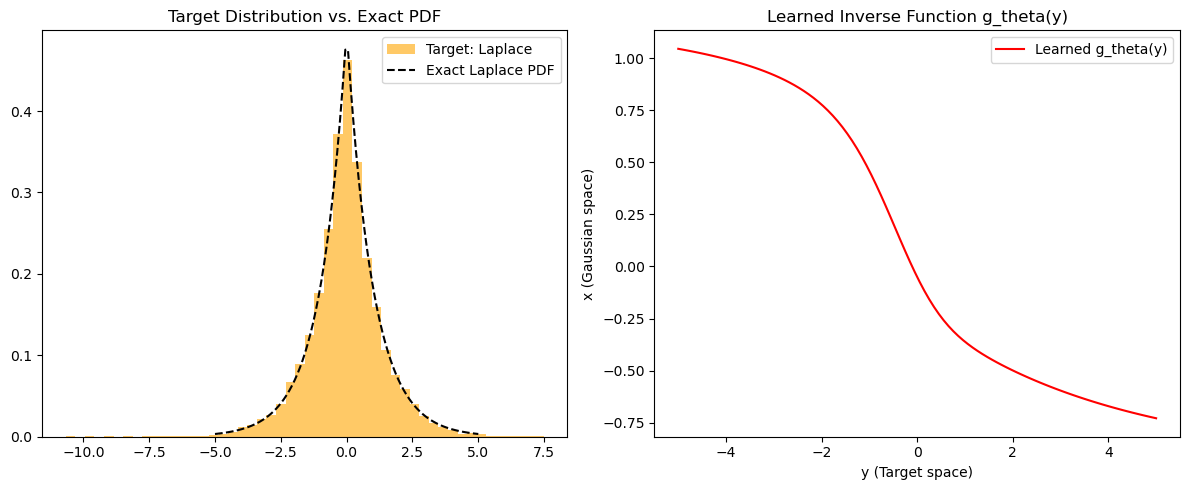

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate samples from the target Laplace distribution: p_Y(y) ∝ exp(-|y|)/2
num_samples = 10000
y_train = np.random.laplace(loc=0.0, scale=1.0, size=num_samples)  # Laplace-distributed samples

# Convert training data to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_train_tensor.requires_grad_(True)  # Ensure gradients are tracked

# Define the Normalizing Flow model (Inverse Function g_theta)
class NormalizingFlow(nn.Module):
    def __init__(self):
        super(NormalizingFlow, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),  # Increased hidden layer size
            nn.Tanh(),          # Changed activation for smooth mapping
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, y):
        return self.net(y)  # Maps Y -> X (inverse function)

# Initialize model, optimizer, and loss function
model = NormalizingFlow()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added L2 regularization

# Function to compute the KL-based loss
def kl_divergence_loss(y_train_tensor, model):
    """Compute KL-divergence loss based on the learned inverse function g_theta."""
    
    # Ensure y_train_tensor requires gradients
    y_train_tensor = y_train_tensor.clone().detach().requires_grad_(True)

    # Compute inverse function: g_theta(Y)
    g_theta_y = model(y_train_tensor)  # Forward pass (inverse function)
    
    # Compute Jacobian using autograd
    jacobian = torch.autograd.grad(
        outputs=g_theta_y, inputs=y_train_tensor, 
        grad_outputs=torch.ones_like(g_theta_y),  
        create_graph=True, retain_graph=True
    )[0]

    # KL-based loss function (Avoid division by zero)
    loss = torch.mean(g_theta_y**2 / (jacobian.abs() + 1e-8))  
    return loss

# Compute Initial Loss Before Training
y_train_tensor.requires_grad_(True)  # Make sure gradients are enabled
initial_loss = kl_divergence_loss(y_train_tensor, model).item()
print(f"Initial Loss (Before Training): {initial_loss:.6f}")

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs + 1):
    optimizer.zero_grad()
    
    y_train_tensor.requires_grad_(True)  # Ensure tracking in every iteration
    loss = kl_divergence_loss(y_train_tensor, model)  # Compute loss

    # Backpropagation
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Print loss at intervals
    if epoch % 2000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Generate test data and apply learned inverse function
y_test = np.linspace(-5, 5, 100).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).requires_grad_(True)

# Get inverse mapped values (X = g_theta(Y))
with torch.no_grad():
    x_learned_vals = model(y_test_tensor).numpy()

# Convert tensors to numpy for plotting
y_train_np = y_train_tensor.detach().cpu().numpy().flatten()
x_learned_vals_np = x_learned_vals.flatten()

# Plot results
plt.figure(figsize=(12, 5))

# ✅ **Plot the target distribution and overlay the exact Laplace PDF**
plt.subplot(1, 2, 1)
plt.hist(y_train_np, bins=50, color='orange', alpha=0.6, label="Target: Laplace", density=True)
y_vals = np.linspace(-5, 5, 100)
exact_laplace_pdf = laplace.pdf(y_vals, loc=0, scale=1)  # Exact Laplace PDF
plt.plot(y_vals, exact_laplace_pdf, 'k--', label="Exact Laplace PDF")  # Overlay
plt.legend()
plt.title("Target Distribution vs. Exact PDF")

# ✅ **Plot the inverse learned function g_theta(y)**
plt.subplot(1, 2, 2)
plt.plot(y_test, x_learned_vals_np, label="Learned g_theta(y)", color='red')
plt.xlabel("y (Target space)")
plt.ylabel("x (Gaussian space)")
plt.legend()
plt.title("Learned Inverse Function g_theta(y)")

plt.tight_layout()
plt.savefig('figs/normalizing_flow_1d_fig_1.png', dpi=300, bbox_inches='tight')
plt.show()